In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import ast
import sys
sys.path.append('machine-scientist/')
sys.path.append('machine-scientist/Prior/')
from mcmc import *
from parallel import *
from fit_prior import read_prior_par

import seaborn as sns
import pyrenn
sns.set(style='ticks')

from pickle import load

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.interpolate import griddata
from scipy.stats import spearmanr
from matplotlib.pyplot import figure
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error


In [2]:
#Read ANN data and model                                                                                        
function='tanh'
n=4;sigma=0.16;realization=0

if sigma==0.1:
    file_data='NN_no_overfit_' + function + '_sigma_0.10_r_' + str(realization) + '_res_0.01.csv'
else:
    file_data='NN_no_overfit_' + function + '_sigma_' + str(sigma) + '_r_' + str(realization) + '_res_0.01.csv'
    
dhr='../data/inter_extrapolate_nns/' + file_data
dhr=pd.read_csv(dhr)


dnhr=dhr[dhr['rep']==n]
dnhr=dnhr[(dnhr['x1']>=-2.0) & (dnhr['x1']<=2.0)]
dnhr.set_index('Unnamed: 0', inplace=True)
dnhr.index.name = None
dnhr=dnhr.reset_index(drop=True)

display(dnhr)

,x1,y,rep,ymodel
0,-1.99,0.000038,4.0,0.928552
1,-1.98,0.000035,4.0,0.772089
2,-1.97,0.000032,4.0,0.626791
3,-1.96,0.000029,4.0,0.494521
4,-1.95,0.000026,4.0,0.376544
...,...,...,...,...
395,1.96,0.996073,4.0,1.024219
396,1.97,0.996190,4.0,1.024247
397,1.98,0.996303,4.0,1.024272
398,1.99,0.996414,4.0,1.024296


In [3]:
#Read BMS trace
steps=50000
NPAR=10
if sigma==0.1:
    filename='BMS_'+function+'_n_'+str(n)+'_sigma_0.10_r_' + str(realization) + '_trace_'+str(steps)+'_prior_'+str(NPAR)+ '.csv'
else:
    filename='BMS_'+function+'_n_'+str(n)+'_sigma_'+str(sigma)+ '_r_' + str(realization) + '_trace_'+str(steps)+'_prior_'+str(NPAR)+ '.csv'
    
trace=pd.read_csv('../data/MSTraces/' + filename, sep=';', header=None, names=['t', 'H', 'expr', 'parvals', 'kk1', 'kk2','kk3'])

#Read original data
if sigma==0.1:
    file_model='NN_no_overfit_' + function + '_sigma_0.10_r_' + str(realization) + '.csv'
else:
    file_model='NN_no_overfit_' + function + '_sigma_' + str(sigma) + '_r_' + str(realization) + '.csv'

model_d='../data/trained_nns/' + file_model
d=pd.read_csv(model_d)
dn=d[d['rep']==n]
dn.set_index('Unnamed: 0', inplace=True)
dn.index.name = None
dn=dn.reset_index(drop=True)

#Parameters to read models
VARS = ['x1',]
x =dnhr[[c for c in VARS]].copy()
y=dnhr.y

if NPAR==10:
    prior_par = read_prior_par('machine-scientist/Prior/final_prior_param_sq.named_equations.nv1.np10.2017-10-18 18:07:35.089658.dat')
elif NPAR==20:
    prior_par = read_prior_par('machine-scientist/Prior/final_prior_param_sq.named_equations.nv1.np20.maxs200.2024-05-10 162907.551306.dat')

#Minimum description length model
minrow = trace[trace.H == min(trace.H)].iloc[0]
minH, minexpr, minparvals = minrow.H, minrow.expr, ast.literal_eval(minrow.parvals)

t = Tree(
    variables=list(x.columns),
    parameters=['a%d' % i for i in range(NPAR)],
    x=x, y=y,
    prior_par=prior_par,
    max_size=200,
    from_string=minexpr,
)

t.set_par_values(deepcopy(minparvals))

299


,x1,y,rep,ymodel,ybms
0,-1.99,0.000038,4.0,0.928552,0.000000
1,-1.98,0.000035,4.0,0.772089,0.000000
2,-1.97,0.000032,4.0,0.626791,0.000000
3,-1.96,0.000029,4.0,0.494521,0.000000
5,-1.94,0.000023,4.0,0.273550,0.000000
...,...,...,...,...,...
393,1.94,0.995829,4.0,1.024157,1.893632
395,1.96,0.996073,4.0,1.024219,1.928135
396,1.97,0.996190,4.0,1.024247,1.945739
397,1.98,0.996303,4.0,1.024272,1.963583


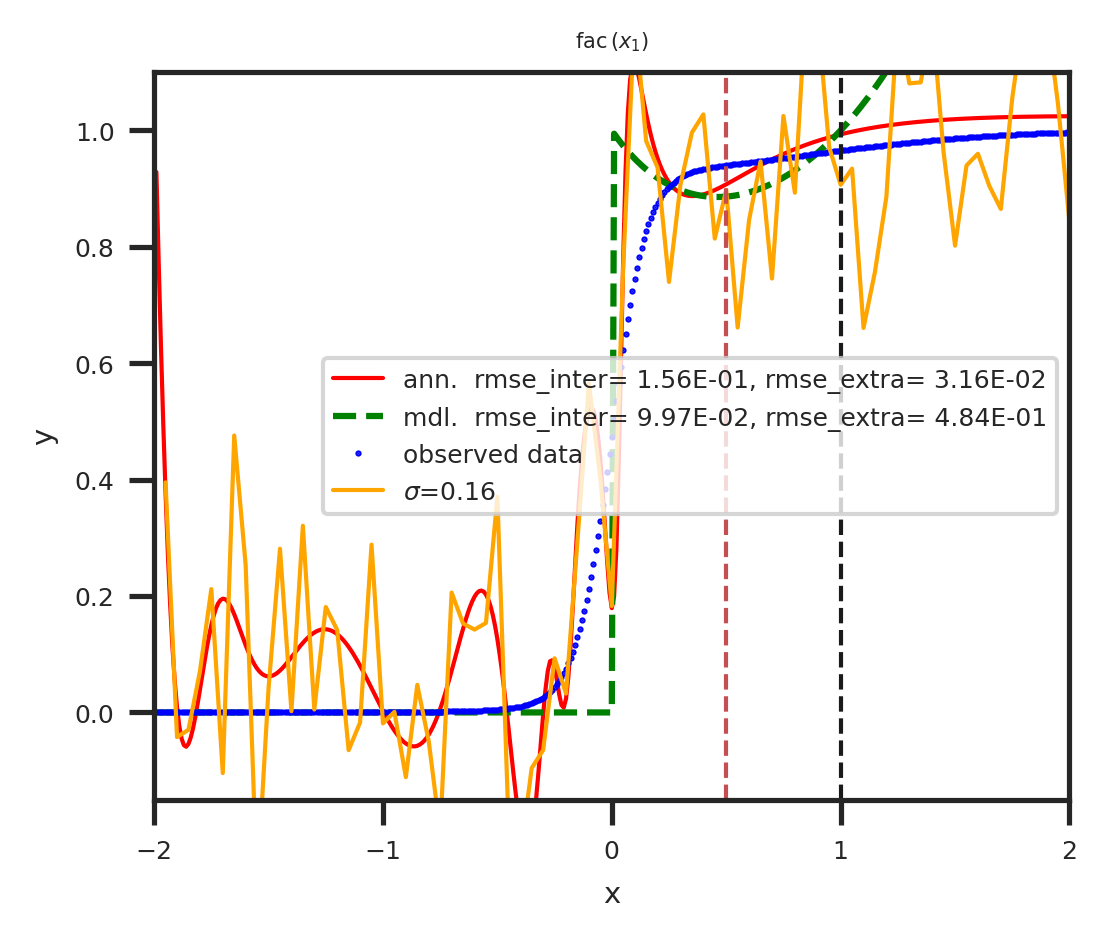

In [4]:
#BMS predictions
train_size_ann=50
validation_border=dn.loc[train_size_ann-1]['x1']

train_value=1.0                                                                               
train_border_row=dnhr[(dnhr['x1']<=1.0) & (dnhr['x1']>=0.99)] 
train_size=train_border_row.index[0]
print(train_size)


dplot = deepcopy(dnhr)
dplot['ybms'] = t.predict(x)
dinterpolate=deepcopy(dplot)
#round values of x1 to two decimals to cross both dataframes
#-------------------------------------------------------------
dinterpolate=dinterpolate.round({'x1':2})
dn=dn.round({'x1':2})
dinterpolate=dinterpolate[-dinterpolate['x1'].isin(dn['x1'].tolist() )] #cross dataframes to get only high resolution points
display(dinterpolate)
#-------------------------------------------------------------

rmse_nn_train=root_mean_squared_error(dinterpolate.loc[:train_size-1]['ymodel'],dinterpolate.loc[:train_size -1]['y'])
rmse_nn_test=root_mean_squared_error(dinterpolate.loc[train_size-1:]['ymodel'],dinterpolate.loc[train_size -1:]['y'])
rmse_mdl_train=root_mean_squared_error(dinterpolate.loc[:train_size-1]['ybms'],dinterpolate.loc[:train_size-1]['y'])

try:
    rmse_mdl_test=root_mean_squared_error(dinterpolate.loc[train_size-1:]['ybms'],dinterpolate.loc[train_size-1:]['y'])
except ValueError:
    rmse_mdl_test=np.inf


#Define figure size in cm                                                                           
cm = 1/2.54 #convert inch to cm                                                                     
width = 10*cm; height=8*cm

Extensions=['.png', '.pdf']

#Fonts and sizes                                                                                    
size_axis=7;size_ticks=6;size_title=5
line_w=1;marker_s=3 #width and marker size  

fig=figure(figsize=(width,height), dpi=300)                                                        

plt.plot(dplot['x1'], dplot['ymodel'],linewidth=line_w, color='red', label='ann.  rmse_inter= %.2E, rmse_extra= %.2E' % ( rmse_nn_train, rmse_nn_test)) 
plt.plot(dplot.x1, dplot.ybms, color='green', linestyle='--',label='mdl.  rmse_inter= %.2E, rmse_extra= %.2E' % ( rmse_mdl_train, rmse_mdl_test)) 
plt.plot(dplot['x1'], dplot['y'],'.', markersize=1, color='blue',label='observed data') 
plt.plot(dn['x1'], dn['y_noise'],linewidth=line_w, markersize=2, color='orange',label=r'$\sigma$=' + str(sigma) ) 

plt.axvline(x=validation_border,linestyle='--',linewidth=line_w, color='r')
plt.axvline(x=train_value,linestyle='--',linewidth=line_w, color='k')

#plt.title('n=%d, r=%d : $%s$' % (n, realization, t.latex()),fontsize=size_title)
plt.title('$%s$' % t.latex(),fontsize=size_title)
plt.xlabel('x',fontsize=size_axis);plt.ylabel('y',fontsize=size_axis)
plt.xticks(fontsize=size_ticks);plt.yticks(fontsize=size_ticks)
plt.legend(loc='best', fontsize=size_ticks)


plt.xlim(-2,2);plt.ylim(-0.15,1.1)  

Name_figure='Interpolation_' + function + '_n_' + str(n) + '_sigma_' + str(sigma) + '_r_'  + str(realization) + '_par_' + str(NPAR)

    
for ext in Extensions:
        plt.savefig('../results/' + Name_figure +ext,dpi=300)

plt.show()